In [11]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt 
import numpy as np
import os

RESULT_DIR = '/media/mcndt/thesis/hydroshoot-prc/src/post_processing/results/gdc_can1_grapevine'
DATA_FILE = os.path.join(RESULT_DIR, 'leaf_data.pickle')
METEO_FILE = os.path.join(RESULT_DIR, 'env_input.csv')


# Reservoir Computing Experiments from HydroShoot gdc_can1_grapevine

In [12]:
# First we load the preprocessed data:

from pickle import load

with open(DATA_FILE, 'rb') as f:
    data = load(f)

In [13]:
properties = list(data.keys())
print(f'Available time series:\n{", ".join(properties)}')

leaf_ids = list(data[properties[0]].keys())
print(f'\n\nAvailable leaf nodes:\n{len(leaf_ids)}')

Available time series:
Ci, E, Flux, psi_head, Tlc, gs, u, Eabs, FluxC, An, gb, Ei, par_photo.dHd


Available leaf nodes:
360


## Experiment 1: reconstructing environmental inputs

Currently we only have one experiment, so we will focus on training loss only. Another option is to leave a subset of the data (e.g. last 4/5 of the series) as validation data, but for this initial run we only have hourly data which might be too little for training already.

### Loading and visualizing environmental input data

NOTE: the meteo file contains hourly data for the entirety of 2012. We can use this to our advantage later to 

- create many experiments using the same model and different sections of the year to vary the inputs
- Train the readout function on a more generalized dataset

In [17]:
# Start by importing the environmental inputs file

import pandas as pd

env_props = ['Tac', 'hs', 'u', 'Rg']

METEO_DESCS = {
    'Tac': 'Air temperature (Celsius)',
    'hs': 'Relative humidity (%)',
    'u': 'Wind speed (m/s)',
    'Rg': 'solar radiation (shortwave irradiance)',
}

meteo_data = pd.read_csv(METEO_FILE)
meteo_data = meteo_data[['time', 'Tac', 'hs', 'u', 'Rg']]
meteo_data['time'] = pd.to_datetime(meteo_data['time'], format='%Y-%m-%d %H:%M:%S')
meteo_data.head(3)

,time,Tac,hs,u,Rg
0,2012-01-01 00:00:00,14.7,58.36,3.146,0.0
1,2012-01-01 01:00:00,14.3,61.21,2.883,0.0
2,2012-01-01 02:00:00,14.5,57.69,2.444,0.0


The initial experiment runs from 2012-08-01 00:00 to 2012-08-04 23:00. So lets extract the meteo data for this timeframe (should be 96 rows).

In [18]:
start = '2012-08-01 00:00:00'
end = '2012-08-04 23:59:59'

input_data = meteo_data[(start <= meteo_data['time']) & (meteo_data['time'] <= end)]

assert(len(input_data) == 96)

Let's plot the data we will try to reconstruct using the reservoir:

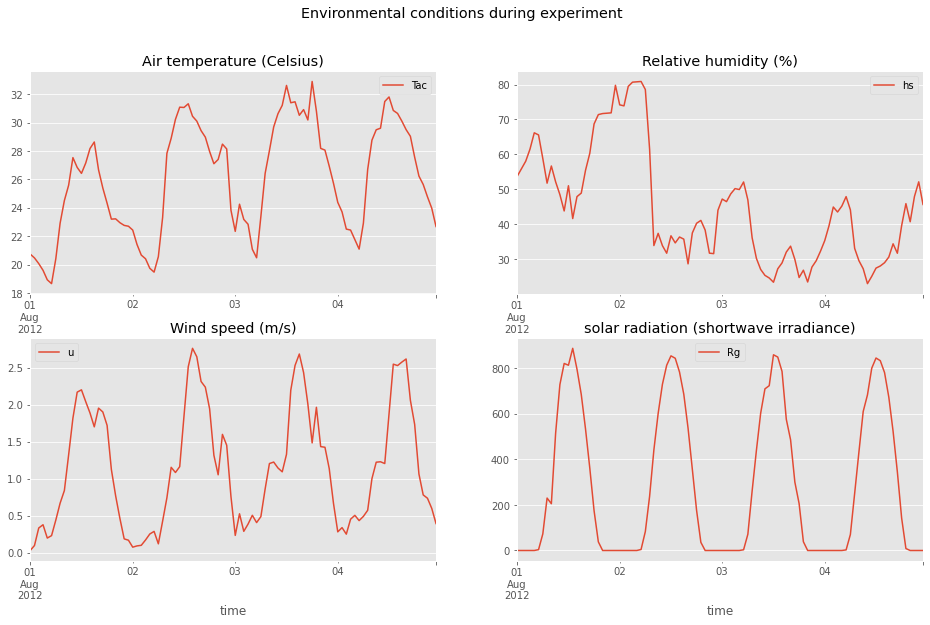

In [19]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    for i, prop in enumerate(env_props):
        input_data.plot(x='time', y=prop, ax=axs[i//2][i%2], title=METEO_DESCS[prop], xlabel='time')
    fig.suptitle('Environmental conditions during experiment', size='x-large')
    plt.show()

### Visualizing the available leaf properties

Now let's take a look at the experimental measurements available from the individual leaves. 

In the following plots we will randomly select $N$ leaves to act as the observable reservoir state.

In [21]:
STATE_SIZE = 64  # max value is 360 for this model

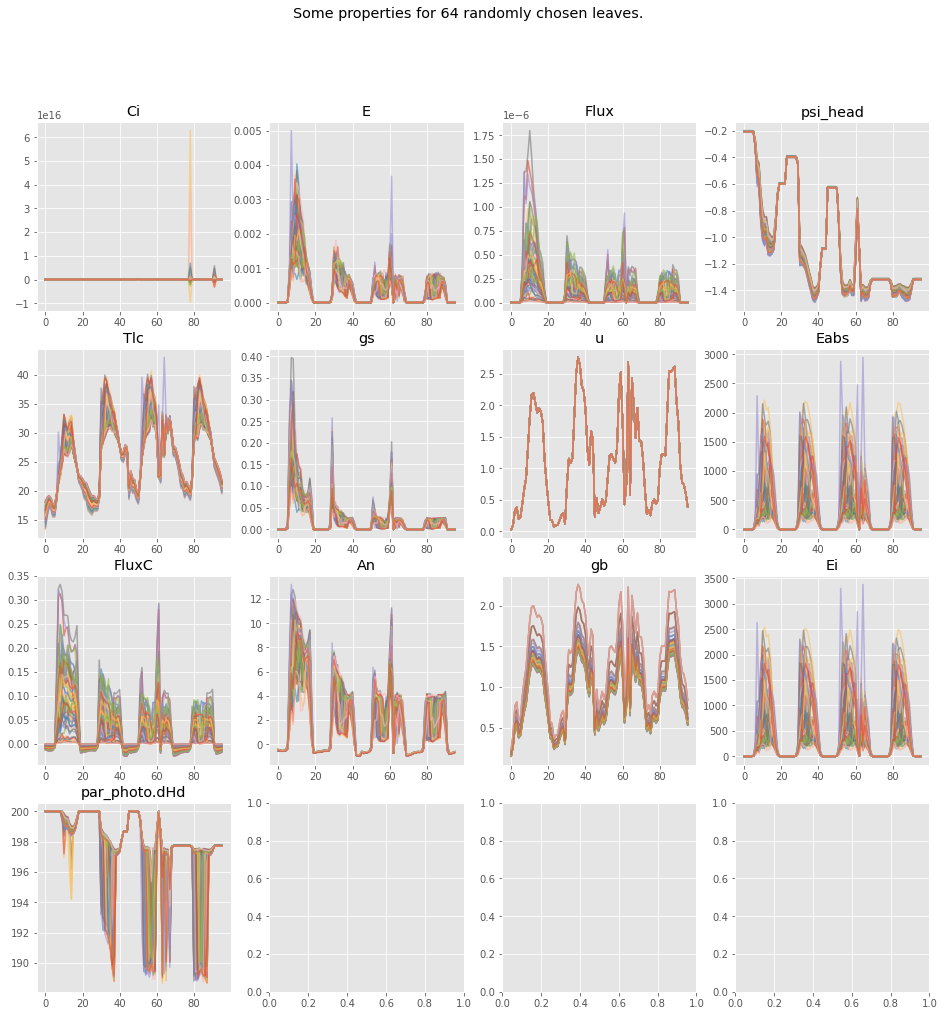

In [23]:
def plot_properties_for_vertices(data, properties, vertex_ids, ncols=4, alpha=0.6):
    cols = min(len(properties), ncols)
    rows = int(np.ceil(len(properties) / cols))
    with plt.style.context('ggplot'):
        fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), squeeze=False)
        for i, prop in enumerate(properties):
            row = i // cols;
            col = i % cols;
            vertices = data[prop]
            for vid in vertex_ids:
                series = vertices[vid]
                axs[row][col].plot(series, alpha=alpha)
                axs[row][col].set_title(prop)
        fig.suptitle(f'Some properties for {len(vertex_ids)} randomly chosen leaves.', size='x-large')
        plt.show()
        
# Select a random subset of leaves to represent 
# the observable reservoir state (out of 360)
np.random.seed(42)
state_ids = np.random.choice(leaf_ids, STATE_SIZE)
plot_properties_for_vertices(data, properties, state_ids)

### Determining leaf property correlation with input series

To have an idea of which property is used best to reconstruct a certain environmental input, we want some form of correlation measure between the leaf property time series and the input time series.

Lets first create a correlation matrix of Pearson correlation coefficients. 

**NOTE:** This statistic does not account for possible delayed response between the two signals! (I think)

In [24]:
# Create a correlation matrix for a random leaf between all leaf properties and all environmental properties
from scipy.stats import pearsonr

np.random.seed(42)
random_leaf = np.random.choice(leaf_ids)

corr_matrix = np.zeros((len(env_props), len(properties)), dtype=float)

for row, env_prop in enumerate(env_props):
    x = input_data[env_prop].to_numpy()
    for col, leaf_prop in enumerate(properties):
        y = data[leaf_prop][random_leaf]
        r, _ = pearsonr(x, y)
        corr_matrix[row, col] = r

In [25]:
def plot_correlation_matrix(M, row_labels, col_labels, title, **kwargs):
    figsize = (16, 4) if 'figsize' not in kwargs else kwargs['figsize']
    cmap = 'coolwarm' if 'cmap' not in kwargs else kwargs['cmap']
    fig, ax = plt.subplots(figsize=figsize)

    img = ax.imshow(M, cmap=cmap)
    for (col, row), value in np.ndenumerate(M):
        ax.text(row, col, f'{value:.2f}', ha='center', va='center')

    ax.set_xticks(np.arange(len(col_labels)))    
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(len(row_labels)))    
    ax.set_yticklabels(row_labels)

    ax.set_title(title)
    plt.colorbar(img)
    plt.show()

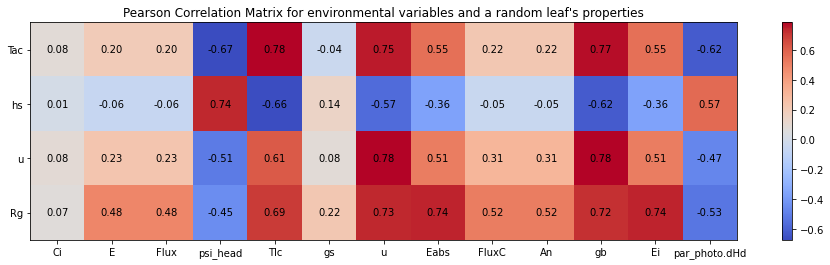

In [26]:
plot_correlation_matrix(corr_matrix, env_props, properties, 'Pearson Correlation Matrix for environmental variables and a random leaf\'s properties')

Let's create a correlation matrix for the mean time series of each property across all leaves.

In [27]:
# Create the mean time series for each property
mean_series = {}

for prop in properties:
    mean_series[prop] = np.zeros(len(input_data), dtype=float)
    for vid in leaf_ids:
        mean_series[prop] += np.array(data[prop][vid])
    mean_series[prop] /= len(leaf_ids)
    
mean_series.pop('Ci')  # This results in some inf values, so remove it. The plot above indicates very low correlation anyways
pass

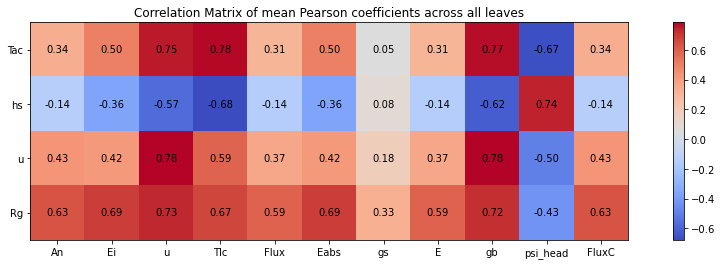

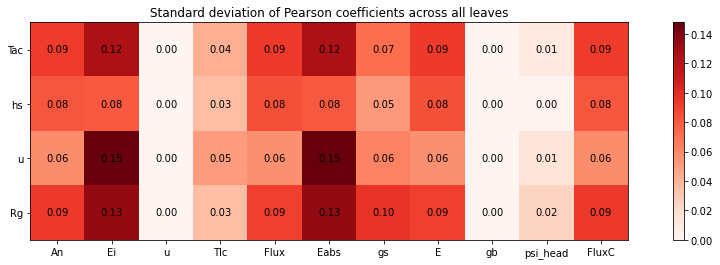

In [28]:
corr_props = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
corr_matrix_all_leafs = np.zeros((len(leaf_ids), len(env_props), len(corr_props)), dtype=float)

for row, env_prop in enumerate(env_props):
    x = input_data[env_prop].to_numpy()
    for col, leaf_prop in enumerate(corr_props):
        for i, leaf_id in enumerate(leaf_ids):
            y = np.array(data[leaf_prop][leaf_id])
            r, _ = pearsonr(x, y)
            corr_matrix_all_leafs[i, row, col] = r
        
corr_matrix_means = corr_matrix_all_leafs.mean(axis=0).reshape((len(env_props), len(corr_props)))

corr_matrix_stdevs = corr_matrix_all_leafs.std(axis=0).reshape((len(env_props), len(corr_props)))

plot_correlation_matrix(corr_matrix_means, env_props, corr_props, 'Correlation Matrix of mean Pearson coefficients across all leaves')
plot_correlation_matrix(corr_matrix_stdevs, env_props, corr_props, 'Standard deviation of Pearson coefficients across all leaves', cmap='Reds')


**Key takeaways:**

1. hs (rel. humidity) is strongly negatively correlated with leaf temperature (Tlc)
2. Stomatal conductance (gb) and leaf temperature (Tlc) are good predictors of temperature (Tac)
3. Stomatal conductance (gb) is highly correlated with wind speed (u)
4. Solar radiation (Rg) is highly correlated with transpiration rates

Overall, the stomatal conductance (`gb`) has quite a strong (positive or negative) correlation with all four environmental input signals, however there seems to be no variation between the signals other than a constant difference (see also the plot of the gb value earlier), which could indicate that this property is modelled quite simplistically and the RC model will not benefit from reading this property from multiple leaves.

## Reservoir computing experiments

The correlations discovered above, the stomatal conductance (`gb`) has quite a strong (positive or negative) correlation with all three environmental input signals,

For these initial experiments, we will limit ourselves to predicting a single environmental input from a single leaf property. We will start with an observable reservoir state of 64 randomly selected leaves.

As in Olivier's paper, we will use the NMSE as loss function:

$$\mathrm{NMSE} = \frac{1}{N} \sum_{t=0}^{N-1} \frac{(y(t) - \hat y(t))^2}{\mathrm{var} (y)}$$

In [31]:
from sklearn.metrics import mean_squared_error

def norm_mean_squared_error(y_true, y_pred, epsilon=1e-12):
  """Computes the normalized MSE between y_true and 
  y_pred, normalized by the variance of y_true."""
  return mean_squared_error(y_true, y_pred) / (y_true.var() + epsilon)

# Perfect predictions have an NMSE of 0.0
assert(norm_mean_squared_error(np.ones((100)), np.ones((100))) == 0)

# Signal mean as prediction results in NMSE of 1.0
y_true = np.random.rand(100)
y_pred = np.ones(100) * y_true.mean()
assert(np.allclose(norm_mean_squared_error(y_true, y_pred), 1))

### Reservoir size 8, homogeneous state variables, predicting environmental input signals

**Goal:** Determine the performance of each leaf variable at predicting each of the environmental signals

In [32]:
# Tlc = leaf temperature. This is also something that can 
# realistically be measured experimentally with thermal cameras.
TARGETS = ['Tac', 'hs', 'u', 'Rg']
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']
STATE_SIZE = 8
N_SAMPLINGS = 100

# Create the array of the reservoir state history.
np.random.seed(42)
# state_ids = np.random.choice(leaf_ids, STATE_SIZE)

states = np.zeros((len(input_data), N_SAMPLINGS, STATE_SIZE, len(STATE_VARIABLES)))  # shape = (time_steps, n_samplings, state_size, state_variables)
# states = np.zeros((len(input_data), STATE_SIZE, len(STATE_VARIABLES)))  # shape = (time_steps, state_size, state_variables)

for r in range(N_SAMPLINGS):
  state_ids = np.random.choice(leaf_ids, STATE_SIZE)
  for i, leaf_id in enumerate(state_ids):
    for j, variable in enumerate(STATE_VARIABLES):
      states[:, r, i, j] = np.array(data[variable][leaf_id])

targets = input_data[TARGETS].to_numpy()

# print(f'States shape: {states.shape} = (time_step, leaf, state_variable)')
print(f'States shape: {states.shape} = (time_step, n_samplings, leaf, state_variable)')
print(f'Target shape: {targets.shape} = (time_step, target_variable)')

States shape: (96, 100, 8, 11) = (time_step, n_samplings, leaf, state_variable)
Target shape: (96, 4) = (time_step, target_variable)


In [33]:
from sklearn.linear_model import Ridge

REGULARIZATION_STRENGTH = 1  # ridge regression parameter

# Make predictions forevery (target, state_variable) combination
y_pred = np.zeros((len(TARGETS), N_SAMPLINGS, len(STATE_VARIABLES), len(input_data)))  # shape = (targets, n_samplings, state_variables, y_pred)
# y_pred = np.zeros((len(TARGETS), len(STATE_VARIABLES), len(input_data)))  # shape = (targets, state_variables, y_pred)

for r in range(N_SAMPLINGS):
  for i, target in enumerate(TARGETS):
    y_true = targets[:, i]
    for j, variable in enumerate(STATE_VARIABLES):
      states_j = states[:, r, :, j]
      readout = Ridge(alpha=REGULARIZATION_STRENGTH)
      readout.fit(states_j, y_true)
      y_pred[i, r, j, :] = readout.predict(states_j)

# Compute NMSE for every (target, state_variable) combination
errors = np.zeros((len(TARGETS), len(STATE_VARIABLES), N_SAMPLINGS))  # shape = (targets, state_variables, n_samplings)
# errors = np.zeros((len(TARGETS), len(STATE_VARIABLES)))  # shape = (targets, state_variables)

for i in range(len(TARGETS)):
  for j in range(len(STATE_VARIABLES)):
    for r in range(N_SAMPLINGS):
      errors[i, j, r] = norm_mean_squared_error(targets[:, i], y_pred[i, r, j, :])

errors_mean = errors.mean(axis=-1)
print(f'errors_mean shape: {str(errors_mean.shape):<8} min: {errors_mean.min():<8.4f} max: {errors_mean.max():<8.4f}')
errors_std = errors.std(axis=-1)
print(f' errors_std shape: {str(errors_std.shape):<8} min: {errors_std.min():<8.4f} max: {errors_std.max():<8.4f}')

errors_mean shape: (4, 11)  min: 0.2221   max: 1.0000  
 errors_std shape: (4, 11)  min: 0.0000   max: 0.0555  


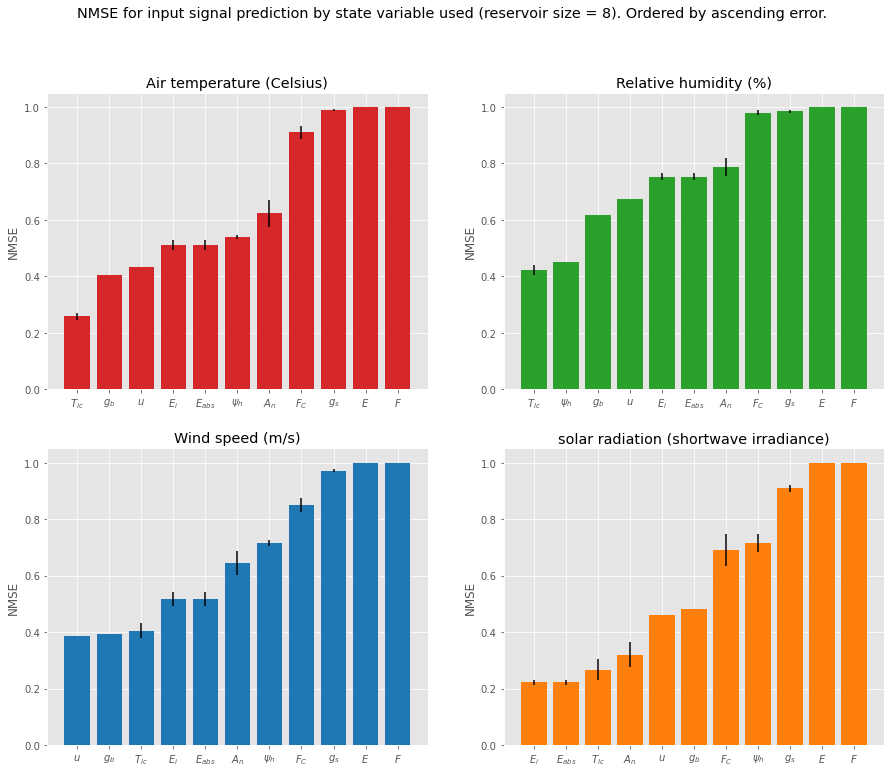

In [34]:
TARGET_COLORS = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']
VARIABLE_NAMES = ['$A_n$', '$E_i$', '$u$', '$T_{lc}$', '$F$', '$E_{abs}$', '$g_s$', '$E$', '$g_b$', '$\psi_{h}$', '$F_C$']

BAR_WIDTH = 0.8

X = np.arange(len(STATE_VARIABLES))

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(2, 2, figsize=(15, 12))

  for i, target in enumerate(TARGETS):
    row = i // 2
    col = i % 2

    ranked_errors_idx = np.argsort(errors_mean[i, :])
    ranked_err_mean = errors_mean[i, ranked_errors_idx]
    ranked_err_std = errors_std[i, ranked_errors_idx]
    ax[row, col].bar(X, ranked_err_mean, BAR_WIDTH, yerr=ranked_err_std, color=TARGET_COLORS[i])

    ax[row, col].set_title(f'{METEO_DESCS[target]}')
    ax[row, col].set_xticks(X)
    ax[row, col].set_xticklabels(np.array(VARIABLE_NAMES)[ranked_errors_idx])
    ax[row, col].set_ylabel('NMSE')

  fig.suptitle(f"NMSE for input signal prediction by state variable used (reservoir size = {STATE_SIZE}). Ordered by ascending error.", size='x-large')
  plt.show()

**Key takeaways:**

- $T_{\mathrm{leaf}}$ is a good reservoir variable for predicting all four inputs, and is also readily observable in vivo.

### Variable reservoir size, homogeneous state variables, predicting input signals

In [ ]:
STATE_SIZES = [1, 2, 4, 8, 16, 32, 64, 128]
N_SAMPLINGS = 100

TARGET = 'Rg'